# Benchmark Specific Visualization

In [1]:
import glob
import gzip
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from modelproblem import ModelProblem
from petab.visualize import plot_problem
from weighted_quantile import weighted_quantile
from result_classes import Result,MethodResults

In [2]:
prob_name = "Boehm_JProteomeRes2014"
methods = ["smc", "pmc"]
colors = sns.color_palette("tab10", n_colors=len(methods))

mod_prob = ModelProblem(prob_name)
mod_prob.initialize()

grouped_results = [MethodResults(x) for x in methods]

for method, group_obj in zip(methods, grouped_results):
	result_dir = f"results/{prob_name}/{method}/"
	fnames = glob.glob(result_dir + "*.pkl")
	for fname in fnames:
		#print(fname)
		with gzip.open(fname, "rb") as f:
			results = pickle.load(f)
		result_obj = Result(results)
		group_obj.add_result(result_obj)
print(type(mod_prob.problem))

<class 'pypesto.problem.base.Problem'>


/home/larkinit/anaconda3/envs/test1/lib/python3.12/site-packages/pypesto/petab/importer.py:487: RuntimeWarning: The following problem parameters were not used: {'dummy'}
  amici.petab.conditions.fill_in_parameters(


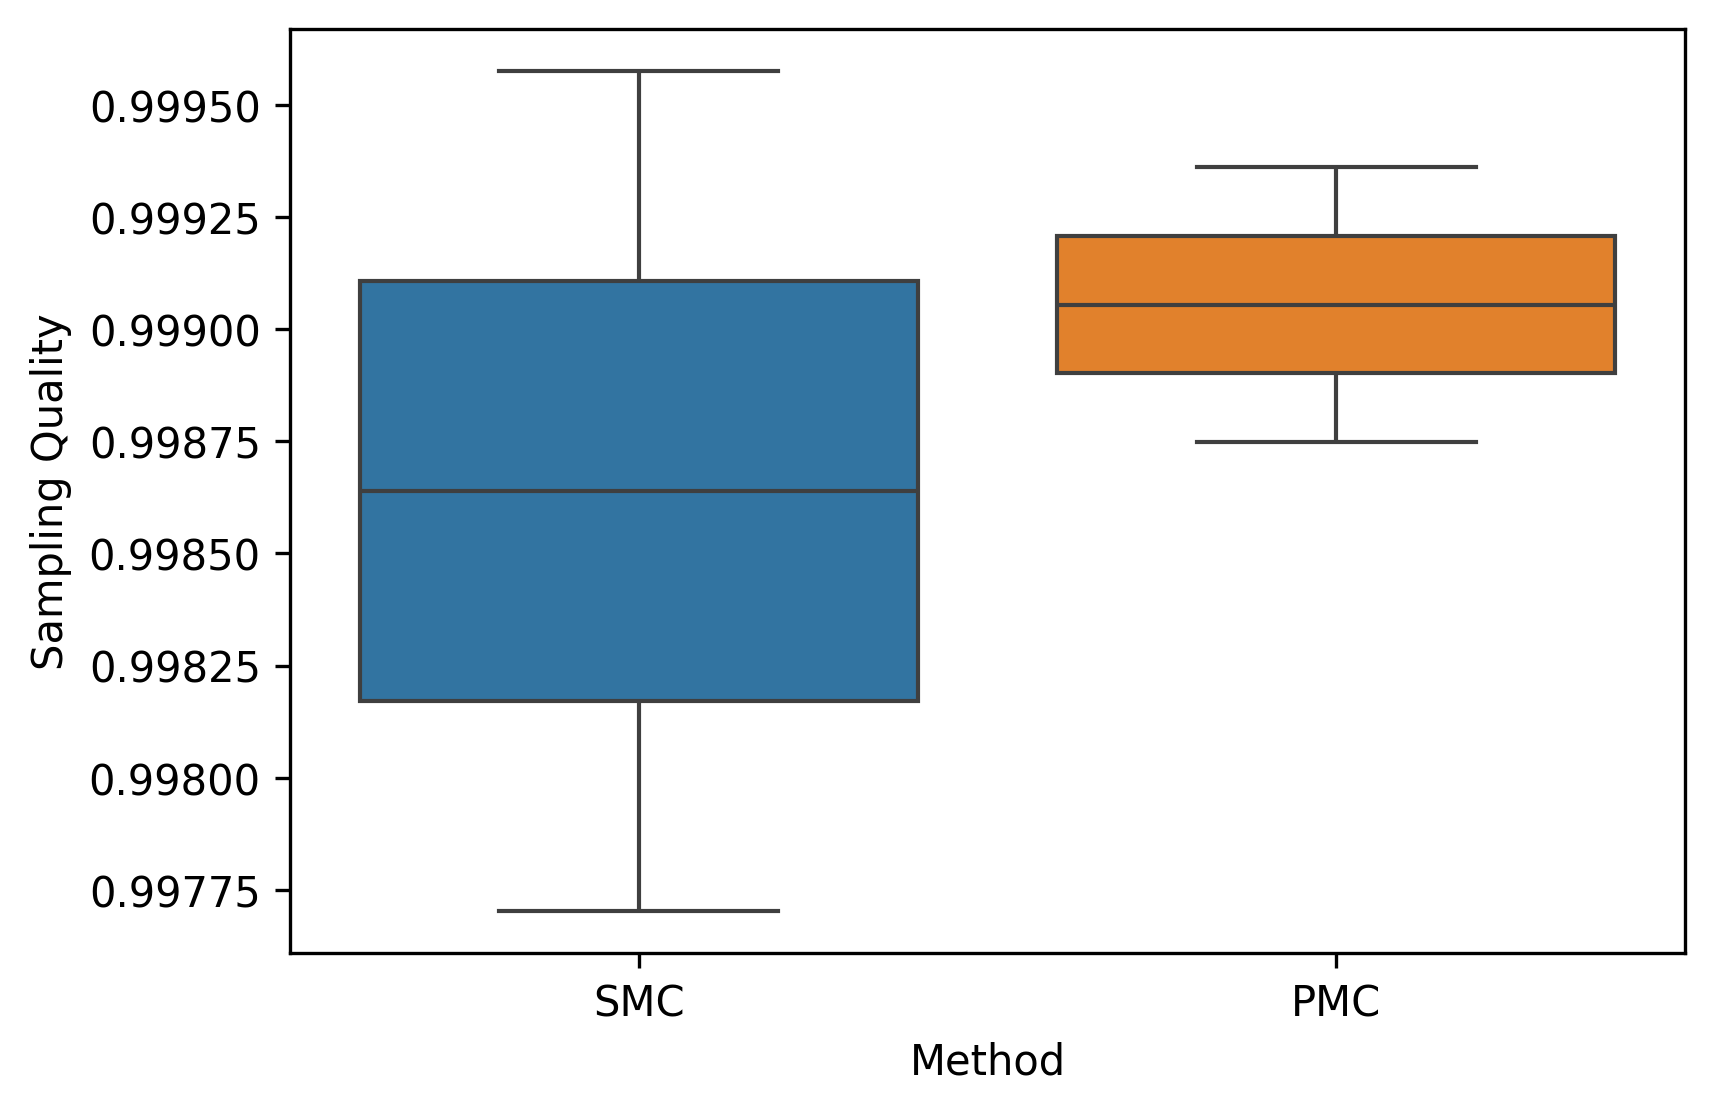

In [3]:
fixed_idxs = mod_prob.problem.x_fixed_indices
par_names = mod_prob.problem.x_names
x=np.array(par_names)
mask=np.full(len(par_names),True,dtype=bool)
mask[fixed_idxs]=False
fit_par_names=x[mask]

dummy_idx = -1

par_bounds = mod_prob.bounds #list(zip(mod_prob.problem.lb_full, mod_prob.problem.ub_full))

plt.figure(figsize=(6,4), dpi=300)
ratios = np.array([x.get_sampling_efficiency(par_bounds, dummy_idx) for x in grouped_results])
ratio_df = pd.DataFrame(columns=methods, data=ratios.T)
#print(ratio_df)
sns.boxplot(ratio_df)#, size=2)
plt.xticks(range(len(methods)), [x.abbr for x in grouped_results])
plt.xlabel("Method"); plt.ylabel(f"Sampling Quality");

## Select best result for each method

In [5]:
llhs = [x.get_avg_llhs() for x in grouped_results]
best_runs = [np.argmax(x) for x in llhs]
best_results = [res.all_runs[best_idx] for best_idx, res in zip(best_runs, grouped_results)]

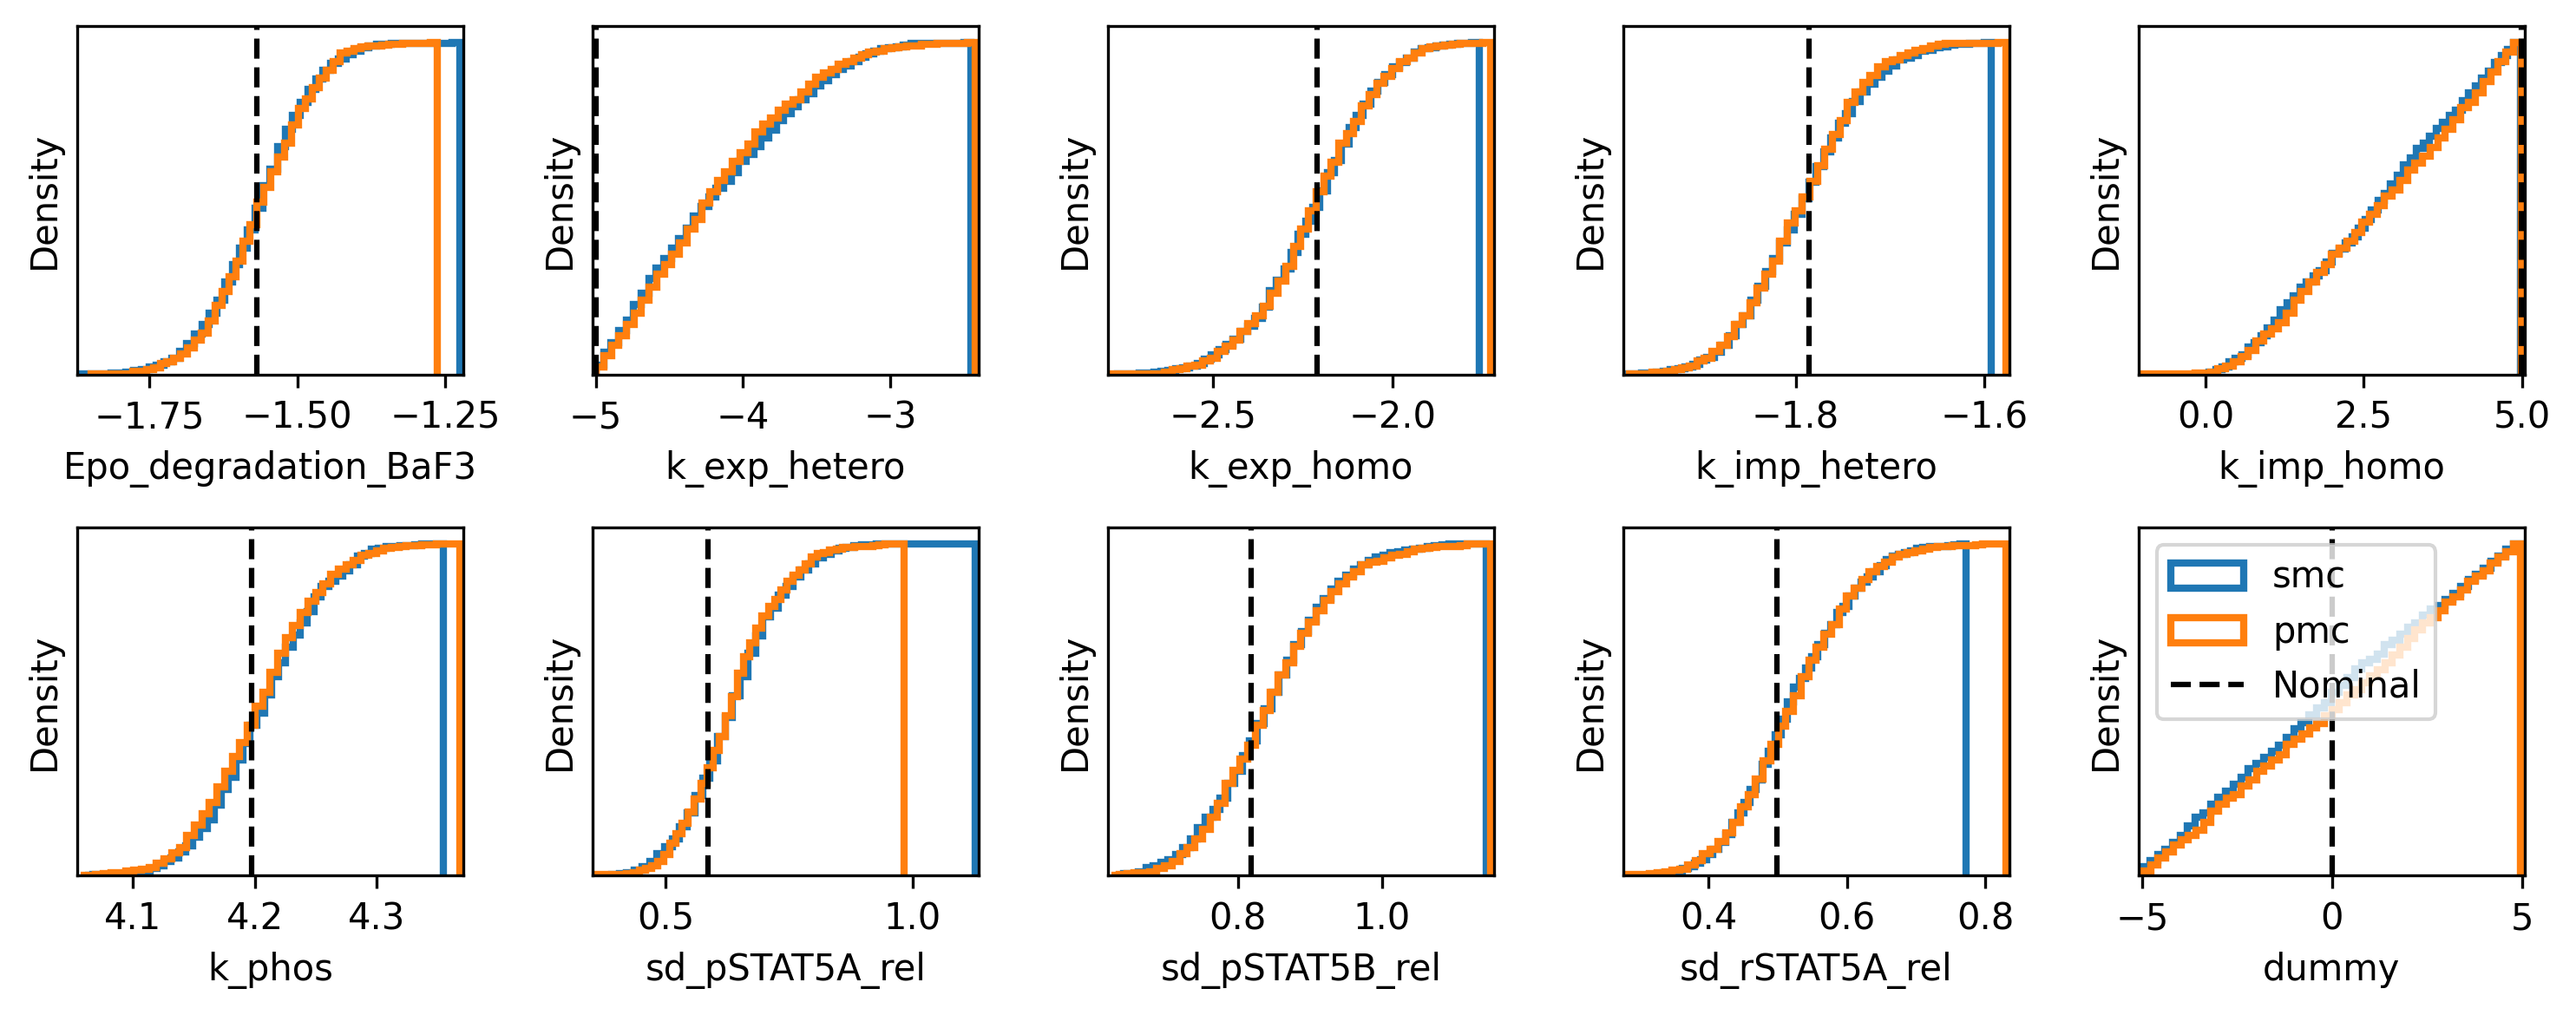

In [10]:
fixed_idxs = mod_prob.problem.x_fixed_indices
par_names = mod_prob.problem.x_names
x=np.array(par_names)
mask=np.full(len(par_names),True,dtype=bool)
mask[fixed_idxs]=False
fit_par_names=x[mask]

par_bounds = mod_prob.bounds
histtype = "step"
alpha=1

xtrue = mod_prob.petab_problem.get_x_nominal(fixed=False, scaled=True)

plt.figure(figsize=(10,4), dpi=300)
for i, par_name in enumerate(fit_par_names): 
	plt.subplot(2,5,i+1)
	for j in range(len(best_results)):      
		cur_result = best_results[j]
		norm_ws = cur_result.posterior_weights
		plt.hist(cur_result.posterior_samples[:, i], lw=2, weights=norm_ws, color=colors[j], alpha=alpha,
			 cumulative=True, histtype="step", bins=50, label=cur_result.method) 
		plt.xlabel(par_name)
		plt.yticks([])
		plt.ylabel("Density")
		plt.margins(x=0.01)
	plt.axvline(x=xtrue[i], ls="--", color="k", label="Nominal")
plt.legend()
plt.tight_layout()

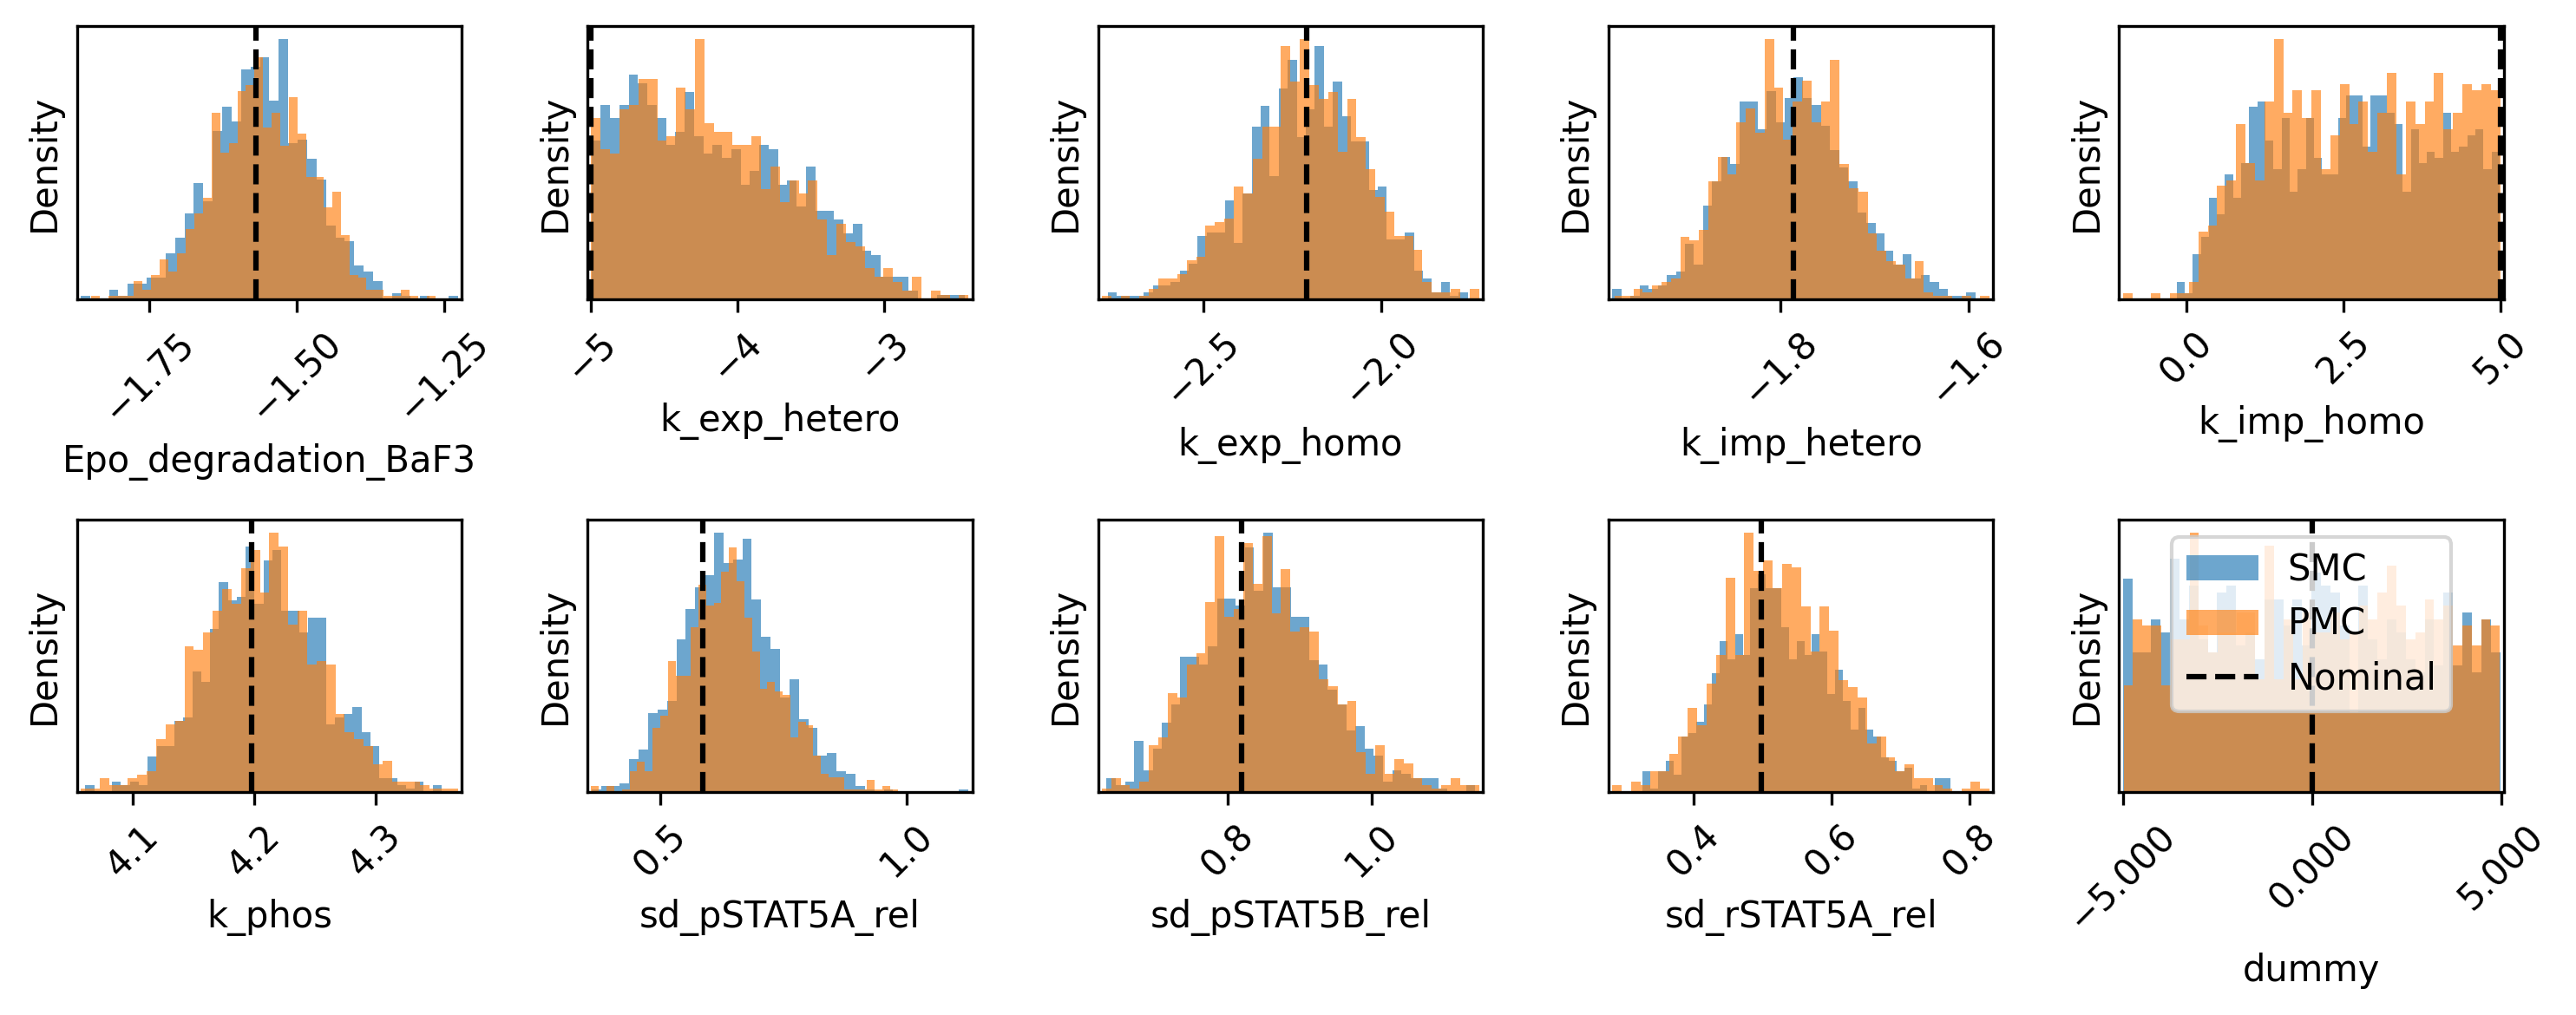

In [12]:
# Get the names of the estimated parameters
fixed_idxs = mod_prob.problem.x_fixed_indices
par_names = mod_prob.problem.x_names
x=np.array(par_names)
mask=np.full(len(par_names),True,dtype=bool)
mask[fixed_idxs]=False
fit_par_names=x[mask]

par_bounds = mod_prob.bounds
xtrue = mod_prob.petab_problem.get_x_nominal(fixed=False, scaled=True)
histtype = "bar"
alpha=0.65

plt.figure(figsize=(10,4), dpi=300)
for i, par_name in enumerate(fit_par_names): 
	plt.subplot(2,5,i+1)
	for j in range(len(best_results)):      
		cur_result = best_results[j]
		plt.hist(cur_result.posterior_samples[:, i], lw=2, weights=cur_result.posterior_weights, color=colors[j], alpha=alpha,
			 cumulative=False, histtype=histtype, bins=40, label=grouped_results[j].abbr) 
	#plt.axvline(x=xtrue[i], ls="--", color="k", label="Nominal", lw=0.75)
	plt.xlabel(par_name)
	plt.xticks(rotation=45)
	plt.yticks([])
	plt.ylabel("Density")
	plt.margins(x=0.01)
	plt.axvline(x=xtrue[i], ls="--", color="k", label="Nominal")
plt.legend()
plt.gca().xaxis.set_major_formatter("{x:.3f}")
#plt.xlim(left=par_bounds[i][0], right=par_bounds[i][1])

plt.tight_layout()

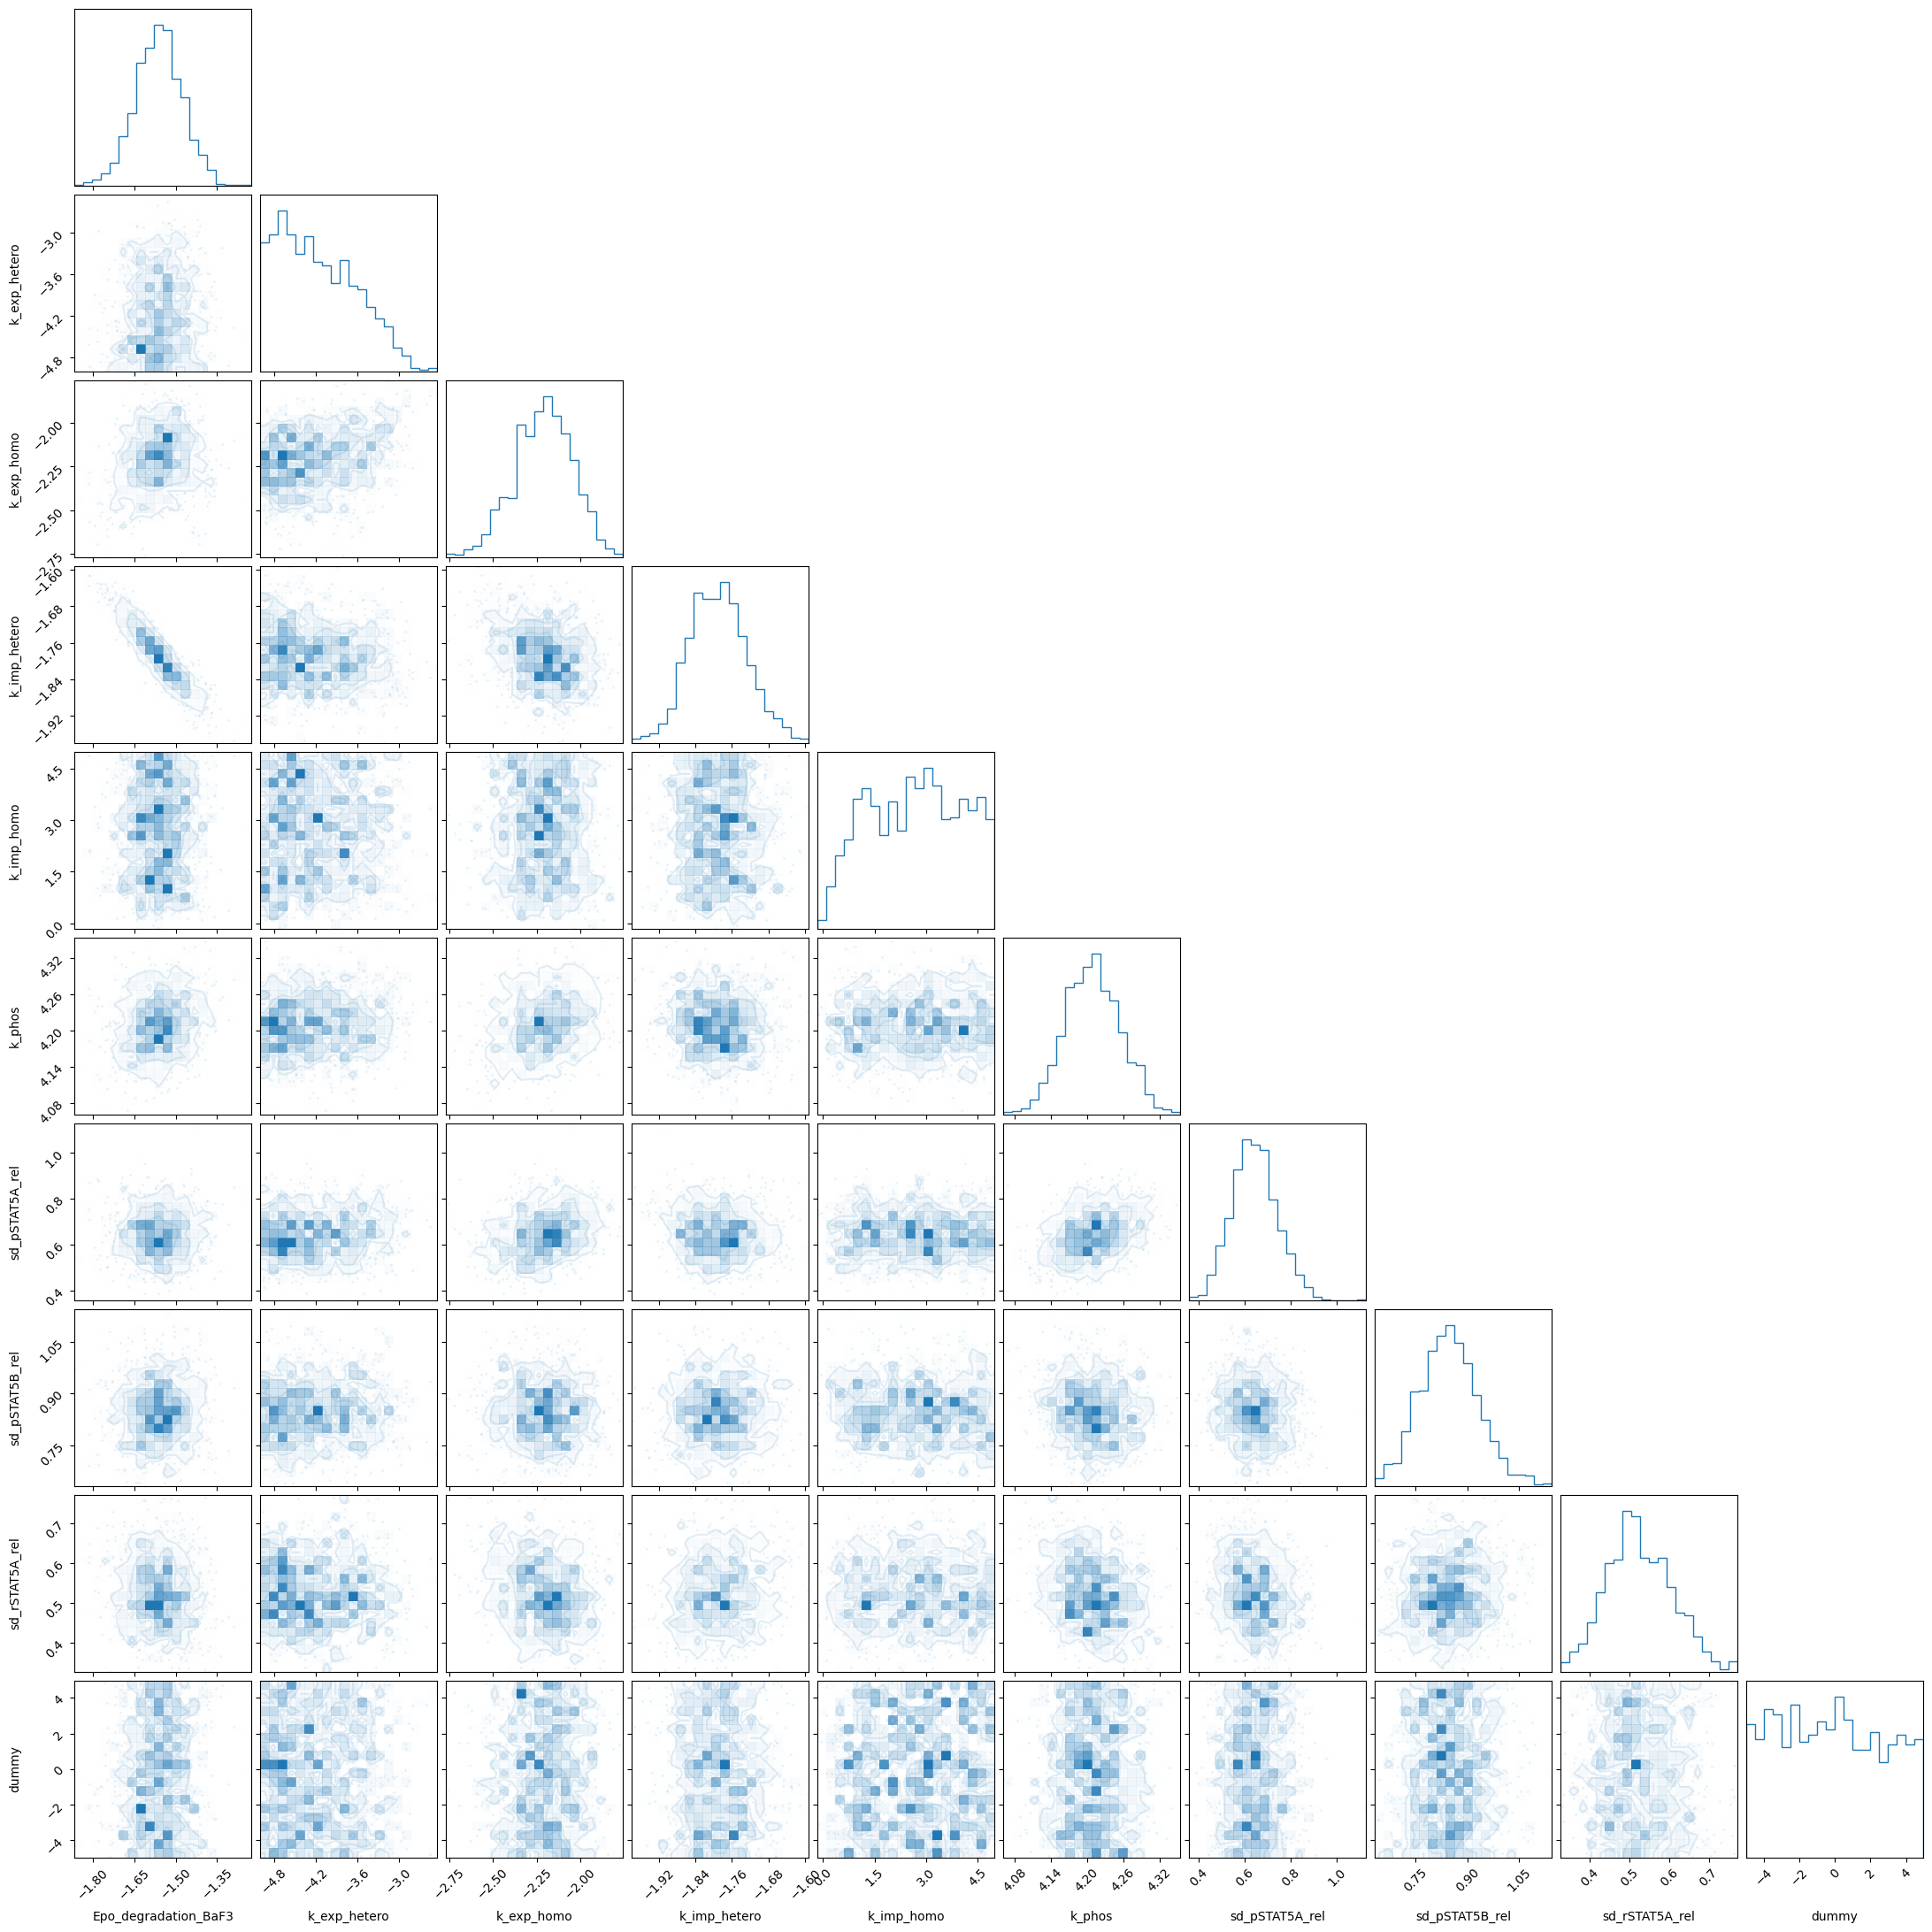

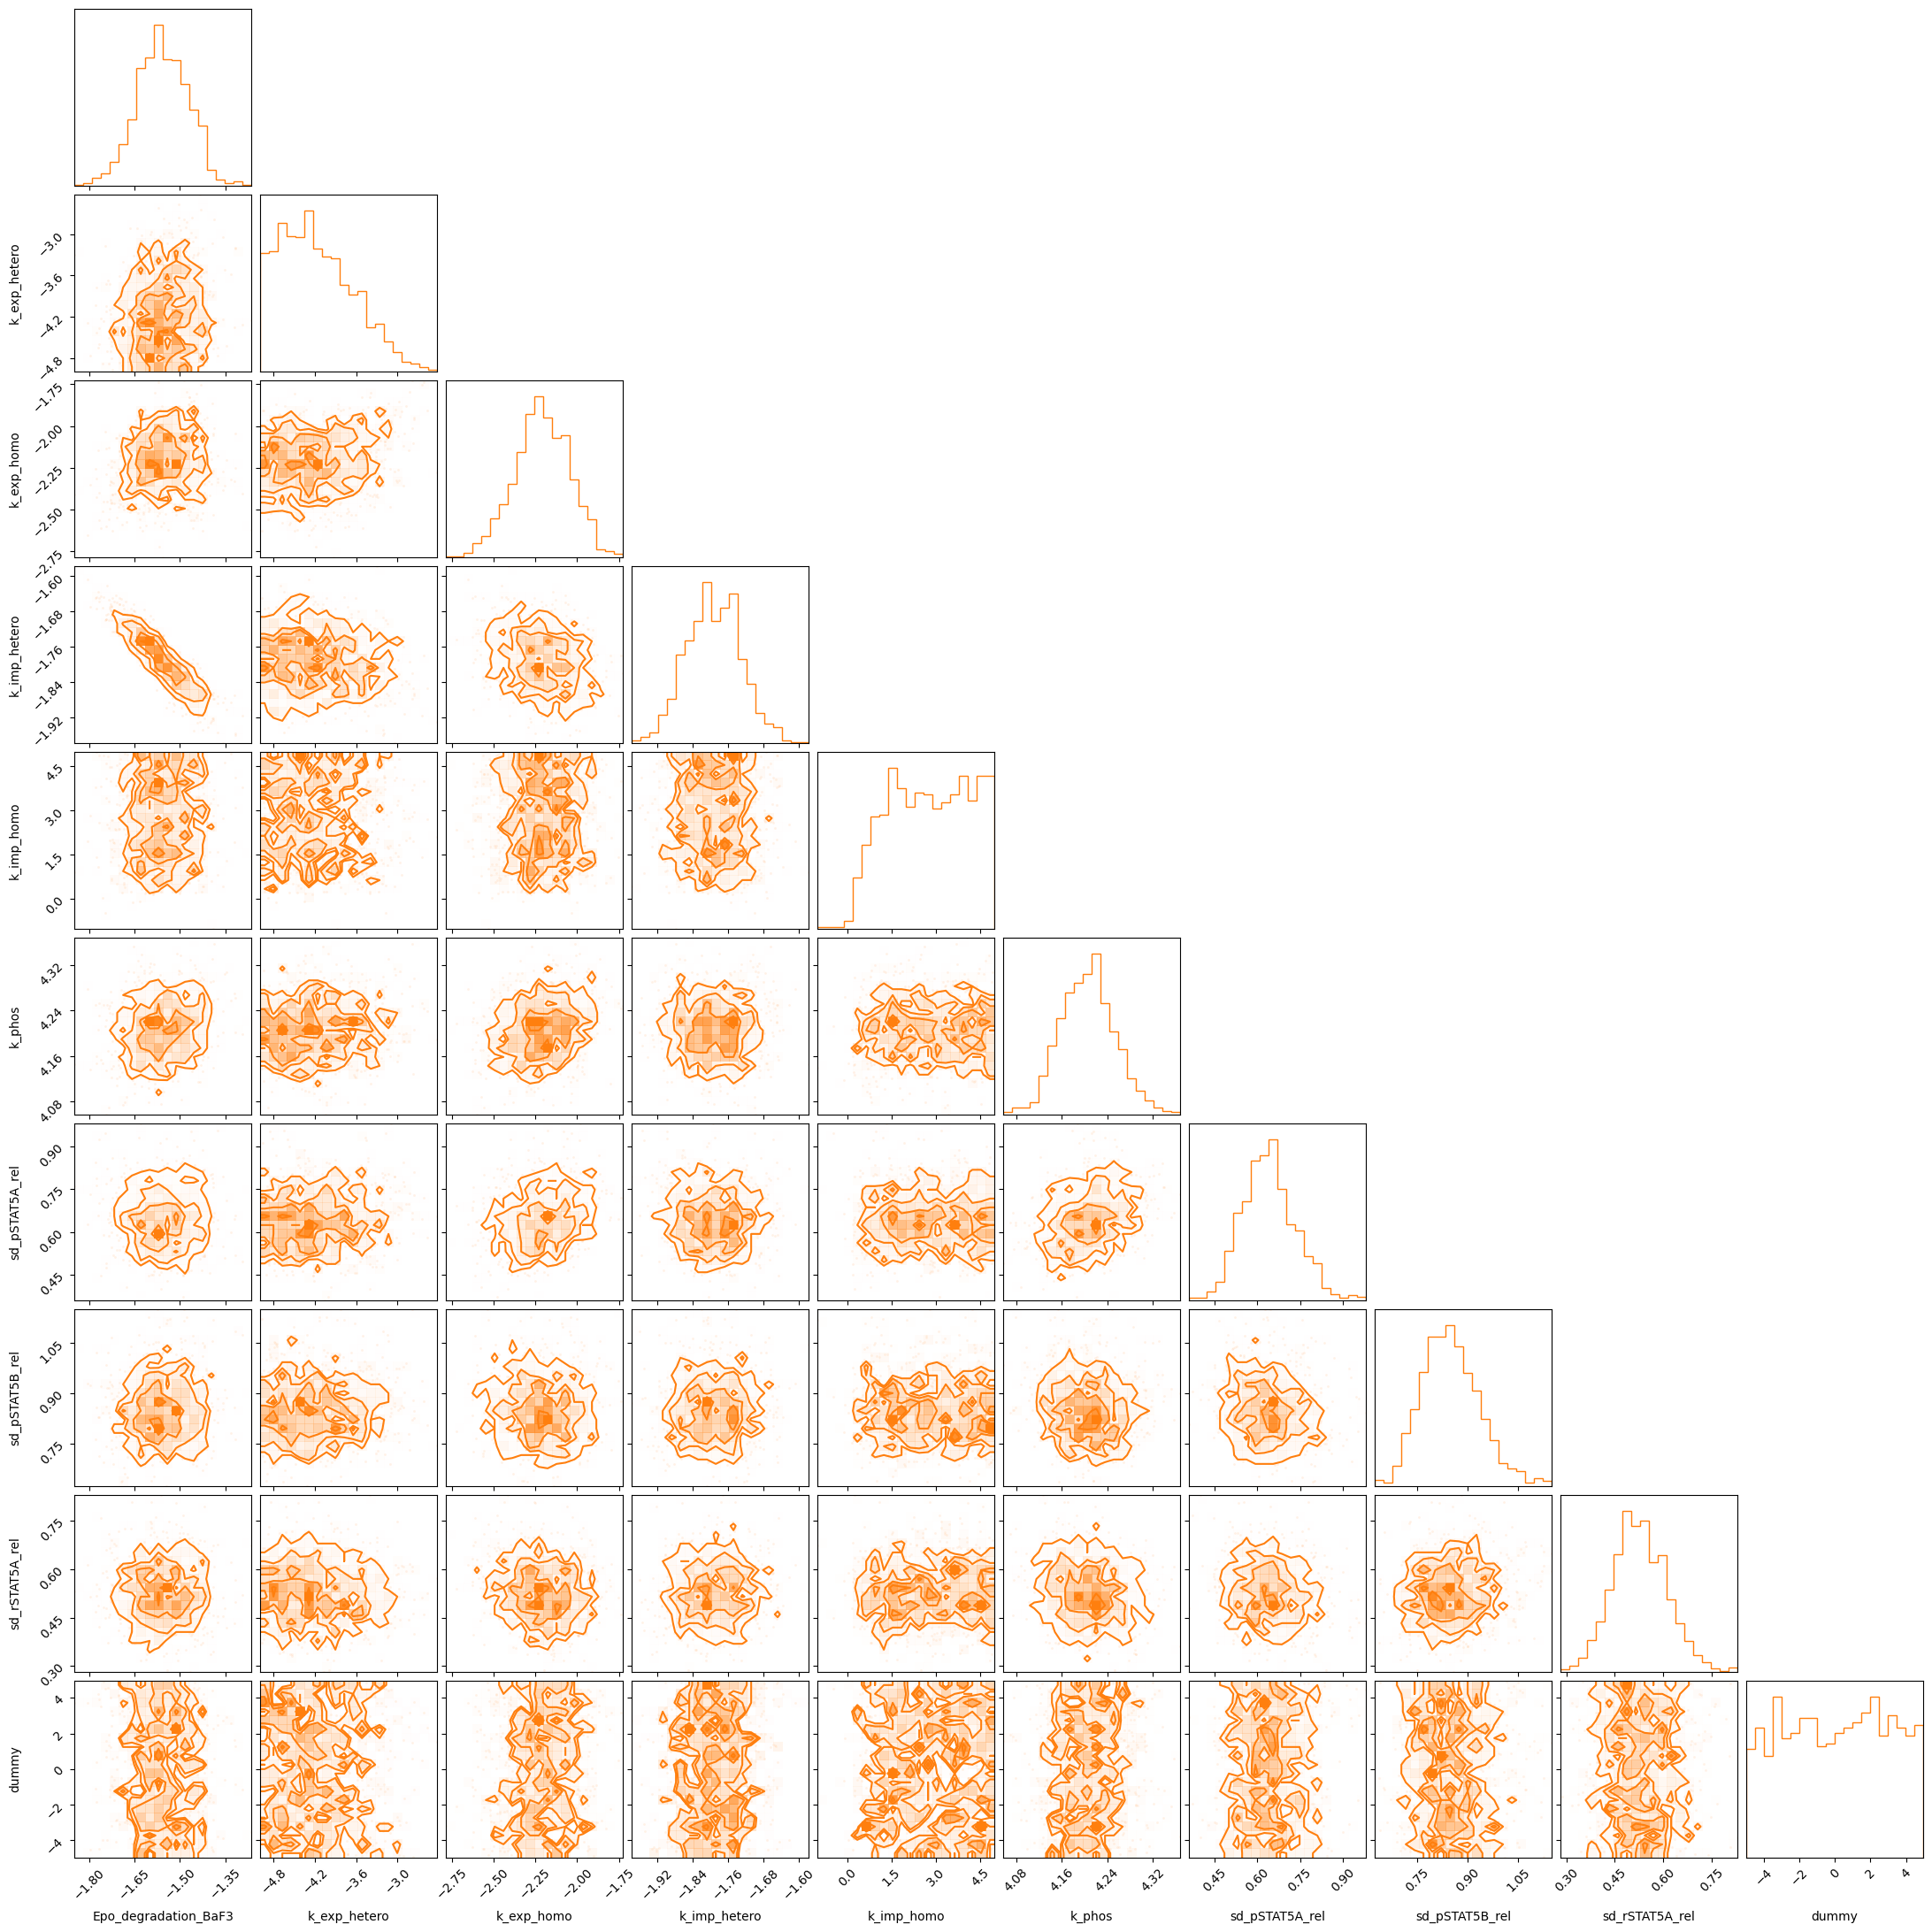

In [13]:
import corner
for i, method in enumerate(methods):
	cur_result = best_results[i]
	param_samples = cur_result.posterior_samples
	norm_ws = cur_result.posterior_weights #np.divide(cur_result.posterior_weights, np.sum(cur_result.posterior_weights))
	corner.corner(param_samples, weights=norm_ws, color=colors[i], labels=fit_par_names)
	

## Plot fits to model data

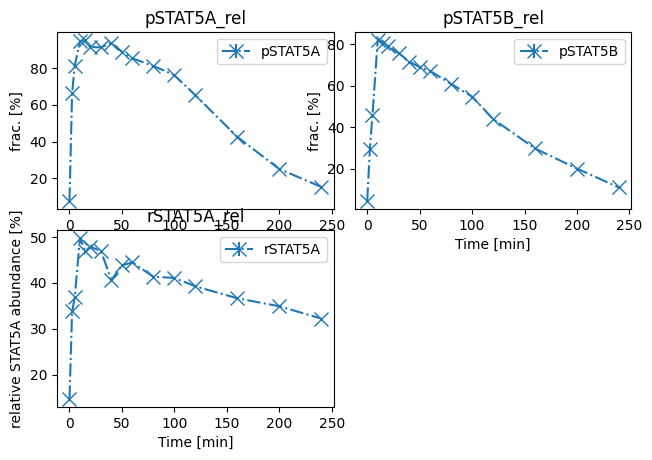

In [17]:
CI = 0.95
UPPER_PCT = (1 - (1-CI)/2)
LOWER_PCT = ((1-CI)/2)

petab_prob = mod_prob.petab_problem
ax_dict = plot_problem(petab_problem=petab_prob,) 
fig = plt.gcf()
# Change the figure size
fig.set_size_inches(6,4)

In [14]:
import petab
sds = petab.v1.measurements.get_measurement_parameter_ids(measure_df)
# Get the names of the estimated parameters
fixed_idxs = mod_prob.problem.x_fixed_indices
par_names = mod_prob.problem.x_names
x=np.array(par_names)
mask=np.full(len(par_names),True,dtype=bool)
mask[fixed_idxs]=False
fit_par_names=x[mask]

all_par_noms = mod_prob.petab_problem.x_nominal
sds_vals = [all_par_noms[list(par_names).index(x)] for x in sds]
for n,s in zip(sds, sds_vals):
	print(f"{n}: {s}")

obs = mod_prob.petab_problem.observable_df
obs_names = obs.index.values
obs_names

NameError: name 'measure_df' is not defined

sd_pSTAT5A_rel: 0.5857552705999998
sd_pSTAT5B_rel: 0.8189828191999999
sd_rSTAT5A_rel: 0.49868440400000047
pSTAT5A_rel
(16, 1000)


/home/larkinit/anaconda3/envs/test1/lib/python3.12/site-packages/pypesto/objective/amici/amici_calculator.py:104: RuntimeWarning: The following problem parameters were not used: {'dummy'}
  amici.petab.conditions.fill_in_parameters(


(16, 1000)
pSTAT5B_rel
(16, 1000)
(16, 1000)
rSTAT5A_rel
(16, 1000)
(16, 1000)


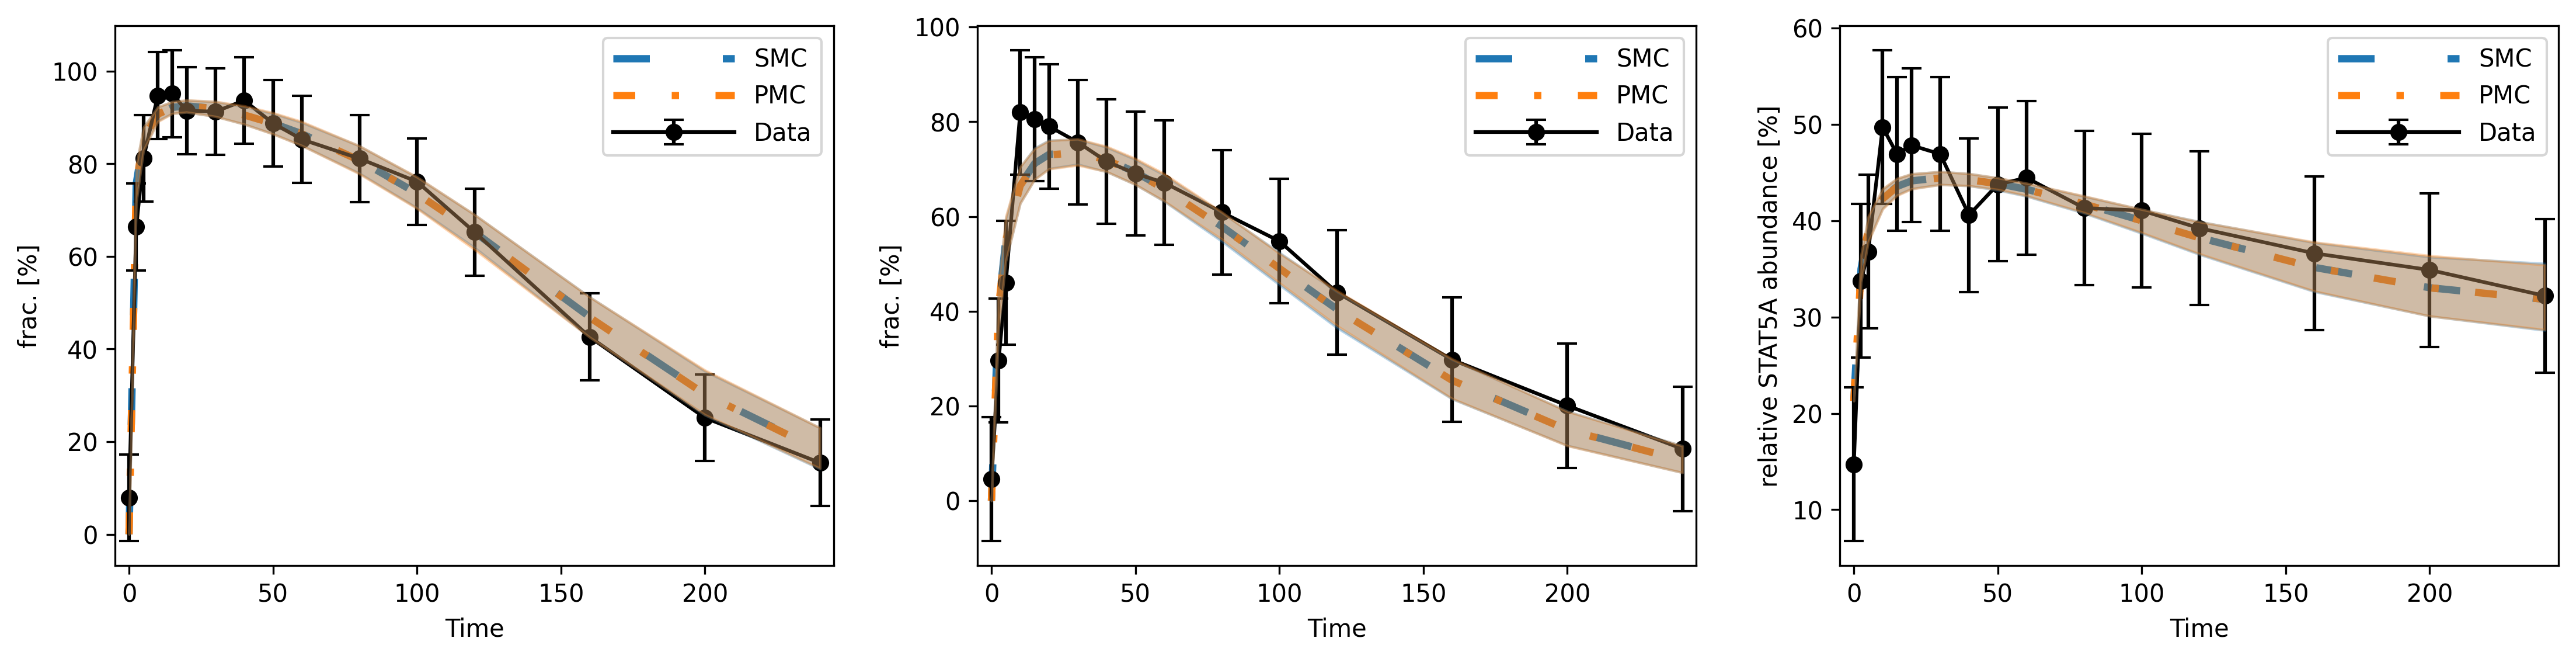

In [18]:
import petab
measure_df = petab_prob.measurement_df
sds = petab.v1.measurements.get_measurement_parameter_ids(measure_df)
# Get the names of the estimated parameters
par_names = mod_prob.problem.x_names

all_par_noms = mod_prob.petab_problem.x_nominal_scaled
sds_vals = [all_par_noms[list(par_names).index(x)] for x in sds]
for n,s in zip(sds, sds_vals):
	print(f"{n}: {s}")

obs = mod_prob.petab_problem.observable_df
obs_names = obs.index.values

obj = mod_prob.problem.objective
model = mod_prob.model

n_species = len(obs_names)
ylabs = ["frac. [%]", "frac. [%]", "relative STAT5A abundance [%]"]
plt.figure(figsize=(18,4), dpi=300)

for j, obs_name, ylab in zip(range(n_species), obs_names, ylabs):
	plt.subplot(int(f"1{n_species}{j+1}"))
	print(obs_name)
	obs_df = measure_df[measure_df["observableId"]==obs_name]

	plt.errorbar(obs_df["time"], obs_df["measurement"], 
					yerr=sds_vals[j]*16, color="k", marker="o", capsize=4, label="Data", zorder=2)
	lss = [(0,(5,10)), (0,(3,5,1,5)), (0,(1,4))]
	for i, best in enumerate(best_results):
		pars = best.posterior_samples
		weights = best.posterior_weights

		all_sim_data = np.empty(shape=(16, pars.shape[0]))
		print(all_sim_data.shape)
		## Collect all of the runs simulation information
		for n, par in enumerate(pars):
			sim = obj(par, mode="mode_fun", return_dict=True)#["simulation_results"]["simCondition"]
			#sim_df = amici.petab_objective.rdatas_to_simulation_df(
			#sim["rdatas"], model, measure_df)
			#print(sim.keys());
			#print(type(sim["rdatas"][0]))
			#print(list(sim["rdatas"][0].keys()))
			rdata = sim["rdatas"][0]

			#print(rdata.get("y").shape)
			all_sim_data[:, n] = rdata.get("y")[:,j]
			sim_ts = rdata.get("ts")
			
		n_ts = len(sim_ts)
		mean_sim_data = np.average(all_sim_data, weights=weights, axis=1)
		temp = np.array([weighted_quantile(x, [LOWER_PCT, UPPER_PCT], weights) for x in all_sim_data])
		#print(temp[0])
		low_sim_data = temp[:, 0]
		high_sim_data = temp[:, 1]

		plt.plot(sim_ts, mean_sim_data, lw=3, linestyle=lss[i], label=grouped_results[i].abbr, zorder=1, color=colors[i])
		plt.fill_between(sim_ts, low_sim_data, high_sim_data, zorder=3, alpha=0.3, color=colors[i])
	plt.legend(handlelength=5)
	plt.margins(x=0.02)
	plt.xlabel("Time"); plt.ylabel(ylab);